In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
params = {
    "Nx": 50,
    "Ny": 100,
    "D_x": 0.1,
    "V_c": 10.0,
    "R_c": 1.0,
    "epsilon": 1e-6,
}

In [3]:
def calculate_S(V, Dx):
    V_i_j = V[:-1, :-1]

    V_ip1_j = V[:-1, 1:]
    V_i_jp1 = V[1:, :-1]

    term_x = ((V_ip1_j - V_i_j) / Dx)**2
    term_y = ((V_i_jp1 - V_i_j) / Dx)**2

    S = (Dx**2 / 2.0) * np.sum(term_x + term_y)
    return S

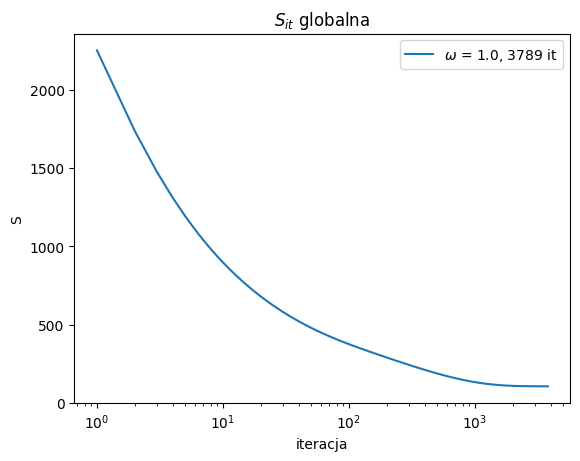

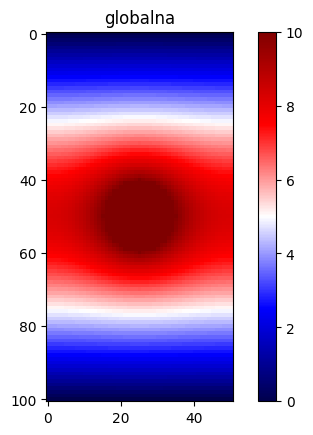

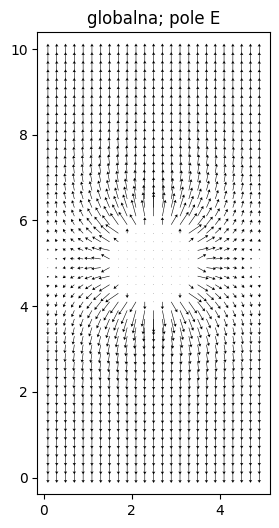

In [71]:
def relax_global(params: dict):
    Nx = params["Nx"]
    Ny = params["Ny"]
    D_x = params["D_x"]
    V_c = params["V_c"]
    R_c = params["R_c"]
    R_c_squared = R_c**2
    epsilon = params["epsilon"]

    R_x = Nx / 2
    R_y = Ny / 2

    V_start = np.zeros((Ny+1, Nx+1), dtype=float)

    x_s, y_s = np.meshgrid(np.arange(Nx+1) - R_x, np.arange(Ny+1) - R_y)
    dists = (D_x*x_s)**2 + (D_x*y_s)**2
    circle_idxs = dists <= R_c_squared

    def reset_to_dirichlet(V):
        V[circle_idxs] = V_c

        V[0, :] = 0.0
        V[-1, :] = 0.0

    reset_to_dirichlet(V_start)

    # Neumann's
    V_start[1:-1, 0] = 0.0
    V_start[1:-1, -1] = 0.0

    V_old = V_start
    prev_S = calculate_S(V_start, D_x)

    all_Ss = []

    MAX_ITER = 10_000
    for i in range(MAX_ITER):
        V_new = V_old.copy()

        V_new[1:-1, 1:-1] = 0.25 * (
            V_old[2:, 1:-1] +
            V_old[0:-2, 1:-1] +
            V_old[1:-1, 2:] +
            V_old[1:-1, :-2]
        )

        reset_to_dirichlet(V_new)

        # Neumann's
        V_new[1:-1, 0] = V_new[1:-1, 1]
        V_new[1:-1, -1] = V_new[1:-1, -2]

        S = calculate_S(V_new, D_x)
        all_Ss.append(S)

        V_old = V_new

        if abs(S - prev_S) < epsilon * abs(prev_S):
            break

        prev_S = S

    return V_old, all_Ss


V, Ss = relax_global(params)

plt.title("$S_{it}$ globalna")
plt.plot(np.arange(1, len(Ss)+1), Ss, label=f"$\omega$ = 1.0, {len(Ss)} it")
plt.xscale("log")
plt.ylabel("S")
plt.xlabel("iteracja")
plt.legend()
plt.show()


plt.title("globalna")
plt.imshow(V, cmap='seismic')
plt.colorbar()
plt.show()


N, M = V.shape
x_full = np.linspace(0, (M-1) * params["D_x"], M)
y_full = np.linspace(0, (N-1) * params["D_x"], N)

X, Y = np.meshgrid(x_full, y_full)
x = X[1:-1, 1:-1]
y = Y[1:-1, 1:-1]

Ex = -(V[1:-1, 2:] - V[1:-1, :-2])/(2 * params["D_x"])
Ey = -(V[2:, 1:-1] - V[:-2, 1:-1])/(2 * params["D_x"])
arrow_step = 2

plt.figure(figsize=(3, 6))
plt.title("globalna; pole E")
plt.quiver(x[::arrow_step, ::arrow_step], y[::arrow_step, ::arrow_step], Ex[::arrow_step , ::arrow_step], Ey[::arrow_step , ::arrow_step], scale =50, headwidth =6)
plt.show()

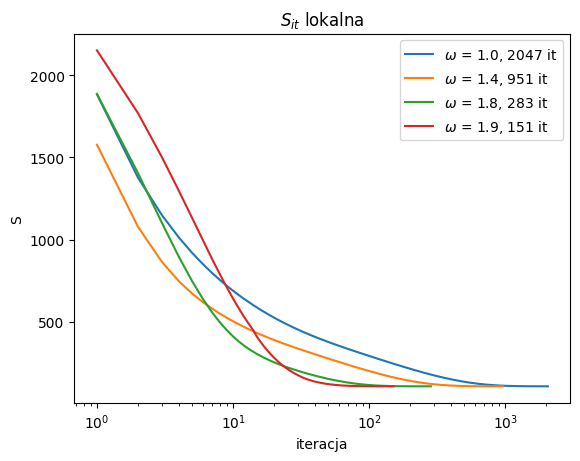

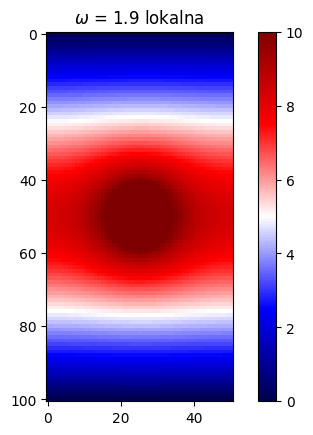

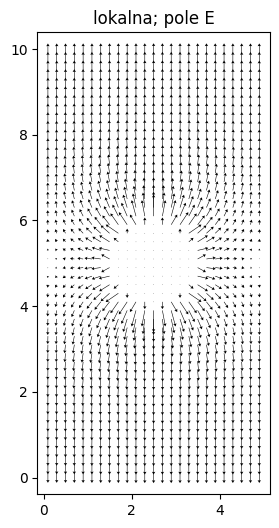

In [75]:
def relax_local(params: dict, omega: float):
    Nx = params["Nx"]
    Ny = params["Ny"]
    D_x = params["D_x"]
    V_c = params["V_c"]
    R_c = params["R_c"]
    R_c_squared = R_c**2
    epsilon = params["epsilon"]

    R_x = Nx / 2
    R_y = Ny / 2

    V = np.zeros((Ny+1, Nx+1), dtype=float)

    x_s, y_s = np.meshgrid(np.arange(Nx+1) - R_x, np.arange(Ny+1) - R_y)
    dists = (D_x*x_s)**2 + (D_x*y_s)**2
    circle_idxs = dists <= R_c_squared

    def reset_to_dirichlet(V):
        V[circle_idxs] = V_c

        V[0, :] = 0.0
        V[-1, :] = 0.0

    reset_to_dirichlet(V)

    # Neumann's
    V[1:-1, 0] = 0.0
    V[1:-1, -1] = 0.0

    prev_S = calculate_S(V, D_x)

    all_Ss = []

    internal_slice = np.s_[1:-1, 1:-1]
    relaxation_mask = ~circle_idxs[internal_slice]

    MAX_ITER = 10_000
    for i in range(MAX_ITER):
        for y in range(1, Ny):
            for x in range(1, Nx):
                if not circle_idxs[y, x]:
                    V_sr = 0.25 * (
                        V[y-1, x] +
                        V[y+1, x] +
                        V[y, x-1] +
                        V[y, x+1]
                    )

                    V[y, x] = (1.0 - omega) * V[y, x] + omega * V_sr

        # Neumann's
        V[1:-1, 0] = V[1:-1, 1]
        V[1:-1, -1] = V[1:-1, -2]

        S = calculate_S(V, D_x)
        all_Ss.append(S)

        if abs(S - prev_S) < epsilon * abs(prev_S):
            break

        prev_S = S

    return V, all_Ss

for omega in [1.0, 1.4, 1.8, 1.9]:
    V, Ss = relax_local(params, omega)

    plt.title("$S_{it}$ lokalna")
    plt.plot(np.arange(1, len(Ss)+1), Ss, label=f"$\omega$ = {omega}, {len(Ss)} it")
    plt.xscale("log")
    plt.ylabel("S")
    plt.xlabel("iteracja")
    plt.legend()

plt.show()


plt.title(f"$\omega$ = {omega} lokalna")
plt.imshow(V, cmap='seismic')
plt.colorbar()
plt.show()


N, M = V.shape
x_full = np.linspace(0, (M-1) * params["D_x"], M)
y_full = np.linspace(0, (N-1) * params["D_x"], N)

X, Y = np.meshgrid(x_full, y_full)
x = X[1:-1, 1:-1]
y = Y[1:-1, 1:-1]

Ex = -(V[1:-1, 2:] - V[1:-1, :-2])/(2 * params["D_x"])
Ey = -(V[2:, 1:-1] - V[:-2, 1:-1])/(2 * params["D_x"])
arrow_step = 2

plt.figure(figsize=(3, 6))
plt.title("lokalna; pole E")
plt.quiver(x[::arrow_step, ::arrow_step], y[::arrow_step, ::arrow_step], Ex[::arrow_step , ::arrow_step], Ey[::arrow_step , ::arrow_step], scale =50, headwidth =6)
plt.show()